<img src="./logo_UTN.svg" align="right" width="150" /> 

#### Procesamiento Digital de Señales

# Trabajo Práctico Nº8
#### Mathilde d'Hébrail





### Configuracion e inicio de la simulacion

In [171]:
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15,5)
import matplotlib.pyplot as plt
import scipy.signal as sg
import warnings
warnings.filterwarnings('ignore')
import math
from scipy.stats import binom
import cmath
import scipy.io as sio
from scipy.io.wavfile import write
import scipy.integrate as integrate
import scipy.special as special
import sounddevice as sd
import pandas as pd


#Esto tiene que ver con cuestiones de presentación de los gráficos,
# NO ES IMPORTANTE
fig_sz_x = 14
fig_sz_y = 13
fig_dpi = 80 # dpi
fig_font_size = 16
plt.rcParams.update({'font.size':fig_font_size})


# ECG

##### Reading the ECG

[('ecg_lead', (1129116, 1), 'double'), ('qrs_pattern1', (113, 1), 'double'), ('heartbeat_pattern1', (411, 1), 'double'), ('heartbeat_pattern2', (441, 1), 'double'), ('qrs_detections', (1903, 1), 'double')]


Text(0.5, 1.0, 'Heartbeat patern 2')

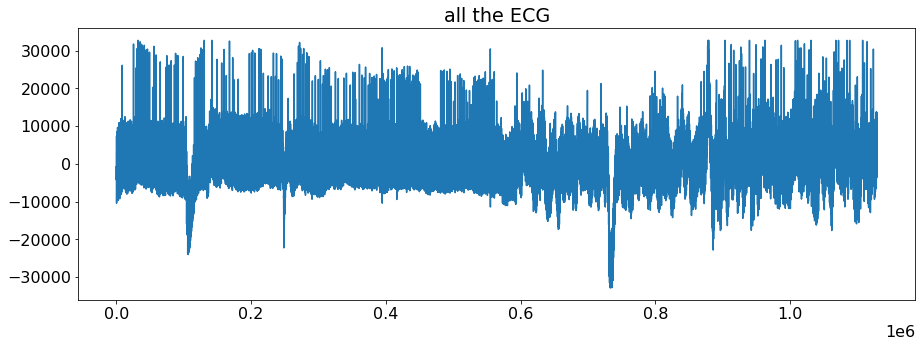

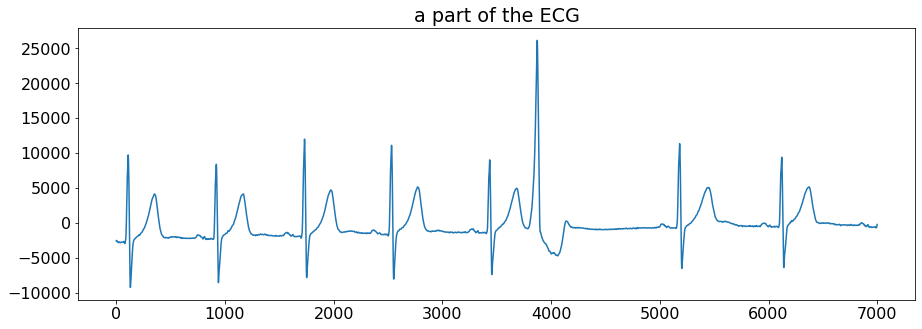

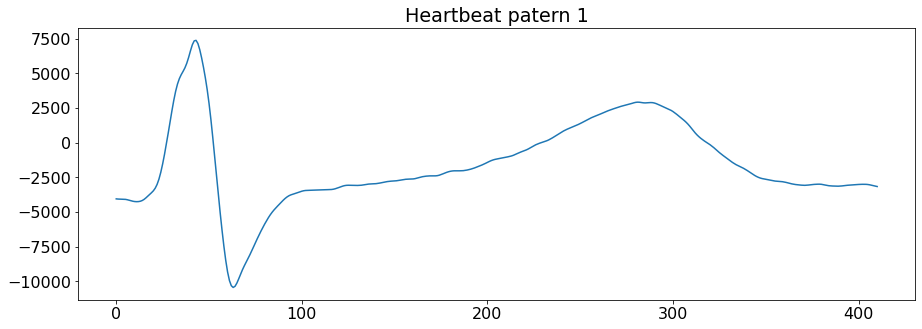

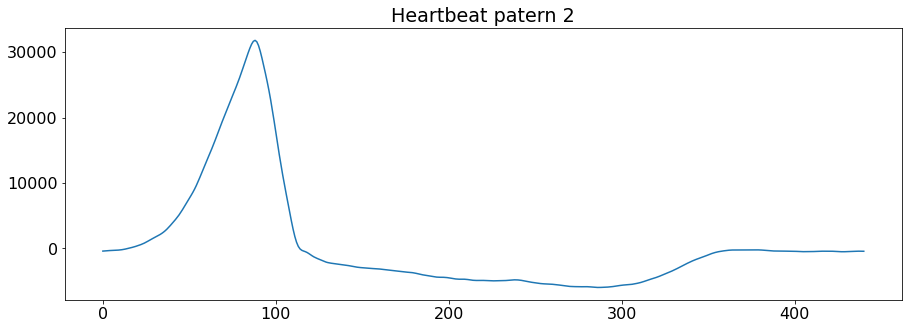

In [172]:
fs_ecg = 1000 # Hz

# para listar las variables que hay en el archivo
print(sio.whosmat('ECG_TP4.mat'))
mat_struct = sio.loadmat('./ECG_TP4.mat')

ecg_one_lead = vertical_flaten(mat_struct['ecg_lead'])

hb_1 = vertical_flaten(mat_struct['heartbeat_pattern1'])
hb_2 = vertical_flaten(mat_struct['heartbeat_pattern2'])

plt.figure(1)
plt.plot(ecg_one_lead)
plt.title("all the ECG")

plt.figure(2)
plt.plot(ecg_one_lead[5000:12000])
plt.title("a part of the ECG")

plt.figure(3)
plt.plot(hb_1)
plt.title("Heartbeat patern 1")

plt.figure(4)
plt.plot(hb_2)
plt.title("Heartbeat patern 2")


In [173]:
data = ecg_one_lead
data = data.flatten()

In [174]:
cut_points = mat_struct['qrs_detections']
print(mat_struct['qrs_detections'])

[[    482]
 [   1240]
 [   1986]
 ...
 [1127113]
 [1127803]
 [1128482]]


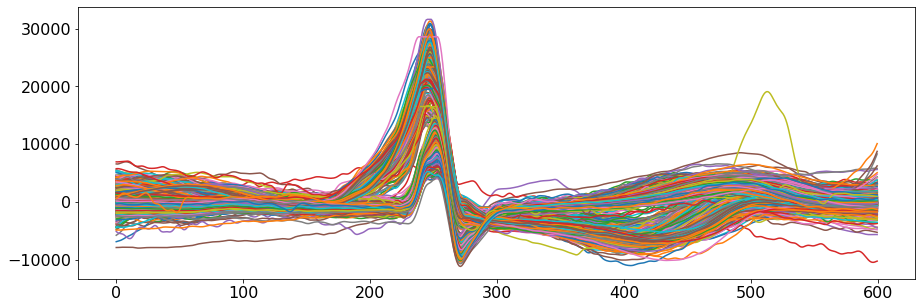

In [212]:
array = []

plt.figure()
for i in range(len(cut_points) - 1):
    segment_start = int(cut_points[i]-250)
    segment_end = int(cut_points[i]+350)
    segment_signal = data[segment_start:segment_end]
    segment_signal = segment_signal - np.mean(segment_signal)
    array.append(segment_signal)
    
    plt.plot(segment_signal)

plt.show()

In [213]:

print(array[:3])

[array([-1.85455667e+03, -1.85855667e+03, -1.85755667e+03, -1.85055667e+03,
       -1.83855667e+03, -1.81855667e+03, -1.79555667e+03, -1.77155667e+03,
       -1.75355667e+03, -1.74455667e+03, -1.74655667e+03, -1.75655667e+03,
       -1.77055667e+03, -1.78555667e+03, -1.79755667e+03, -1.80555667e+03,
       -1.80855667e+03, -1.80855667e+03, -1.80355667e+03, -1.79555667e+03,
       -1.78755667e+03, -1.78155667e+03, -1.78255667e+03, -1.78955667e+03,
       -1.80255667e+03, -1.81555667e+03, -1.82355667e+03, -1.82355667e+03,
       -1.81655667e+03, -1.80455667e+03, -1.79255667e+03, -1.78555667e+03,
       -1.78855667e+03, -1.80055667e+03, -1.81855667e+03, -1.83655667e+03,
       -1.84855667e+03, -1.85255667e+03, -1.84855667e+03, -1.84155667e+03,
       -1.83455667e+03, -1.82655667e+03, -1.82055667e+03, -1.81255667e+03,
       -1.80455667e+03, -1.79455667e+03, -1.78255667e+03, -1.76955667e+03,
       -1.75955667e+03, -1.75855667e+03, -1.76955667e+03, -1.78855667e+03,
       -1.80855667e+03, 

In [214]:
array = np.array(array)

In [215]:
print(array[:3])

[[-1854.55666667 -1858.55666667 -1857.55666667 ...  -755.55666667
   -756.55666667  -751.55666667]
 [-1529.985      -1515.985      -1496.985      ... -1022.985
  -1039.985      -1055.985     ]
 [-1538.41       -1544.41       -1540.41       ... -1129.41
  -1121.41       -1116.41      ]]


In [216]:
array_transposed = array.T

In [218]:
new_ecg = [np.mean(array_transposed[i]) for i in range(len(array_transposed))]

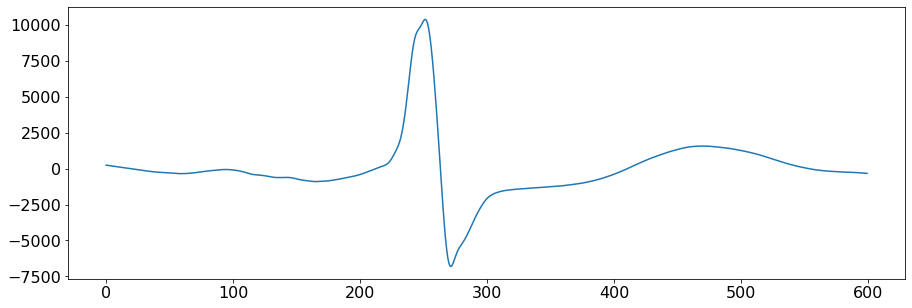

In [220]:
plt.figure
plt.plot(new_ecg)
plt.show()

In [254]:
new_fft = (1/600)* np.fft.fft(array, axis = 0)


def normalize(d):
    # d is a (n x dimension) np array
    somme = np.sum(d)
    d = d/somme
    return d
#new_fft = normalize(new_fft)
#new_fft = new_fft - np.mean(new_fft)
new_fft[:fs_ecg//2].shape

(500, 600)

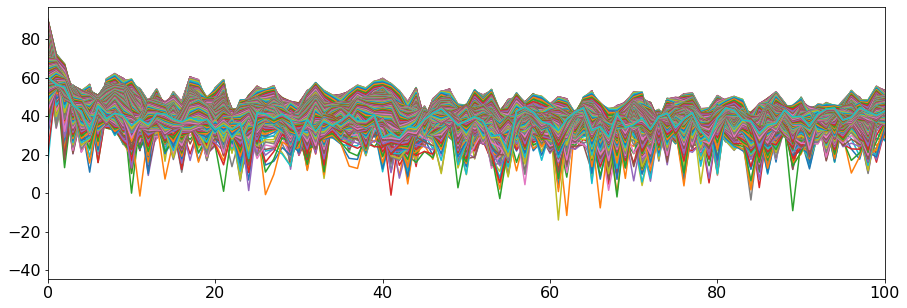

In [255]:
plt.figure
plt.plot(20*np.log10(np.abs(new_fft[:fs_ecg//2])))
plt.xlim(0, 100)
plt.show()